In [8]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn import metrics

%matplotlib inline

## Pre-Task: Describe the goals of your study

Predict the survival probabily of Titanic passengers.

## Part 1: Aquire the Data

#### 1. Connect to the remote database

In [9]:
# Because doesn't have `DESCRIBE [table]`
def describe_table(table="orders", connection=engine):
    
    sql = """
    SELECT
        column_name, data_type
    FROM
        information_schema.COLUMNS
    WHERE
        TABLE_NAME = '%s'
    """ % table

    return pd.read_sql(sql, con=connection)

In [10]:
from sqlalchemy import create_engine
import pandas as pd
import connection
engine = create_engine(connection.params)

pd.read_sql("SELECT * FROM pg_catalog.pg_tables WHERE schemaname='public'", con=engine)

,schemaname,tablename,tableowner,tablespace,hasindexes,hasrules,hastriggers
0,public,train,dsi,None,True,False,False
1,public,table1,dsi_student,None,True,False,False


In [11]:
describe_table("train", connection=engine)

,column_name,data_type
0,index,bigint
1,PassengerId,bigint
2,Survived,bigint
3,Pclass,bigint
4,Name,text
5,Sex,text
6,Age,double precision
7,SibSp,bigint
8,Parch,bigint
9,Ticket,text


#### 2. Query the database and aggregate the data

In [12]:
## General Look
sql = """
SELECT * 
From train 
LIMIT 3
"""
pd.read_sql(sql, con=engine)

,index,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,None,S
1,1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,None,S


In [13]:
## Number of Males and Females
sql = """
SELECT "Sex", COUNT("Sex") AS ct_sex
FROM train
GROUP BY "Sex"
"""
pd.read_sql(sql, con=engine)

,Sex,ct_sex
0,male,577
1,female,314


In [14]:
## Missing Obervations 
sql = """
SELECT "Age", COUNT("Sex") AS ct_sex, "Sex"
From train
GROUP BY "Sex", "Age"
ORDER BY "Age" DESC
"""
pd.read_sql(sql, con=engine)
## Result is 124 missing Ages for male 
## Result is 53 missing Ages for female

,Age,ct_sex,Sex
0,NaN,124,male
1,NaN,53,female
2,80.00,1,male
3,74.00,1,male
4,71.00,2,male
5,70.50,1,male
6,70.00,2,male
7,66.00,1,male
8,65.00,3,male
9,64.00,2,male


In [15]:
## How many survived by sex 
sql = """
SELECT "Sex", COUNT("Survived") AS ct_surv, "Survived"
From train 
GROUP BY ("Survived"), "Sex"
LIMIT 4
"""
pd.read_sql(sql, con=engine)
## 233 Females Survived and 109 Males

,Sex,ct_surv,Survived
0,male,468,0
1,female,233,1
2,male,109,1
3,female,81,0


In [16]:
## Passenger class by sex
sql = """
SELECT "Pclass", "Sex", COUNT("Sex") AS ct_sex
FROM train
GROUP BY "Sex", "Pclass"
ORDER BY "Sex", "Pclass"
"""
pd.read_sql(sql, con=engine)

,Pclass,Sex,ct_sex
0,1,female,94
1,2,female,76
2,3,female,144
3,1,male,122
4,2,male,108
5,3,male,347


In [17]:
## Passenger Survived by class
sql= """
SELECT "Pclass", "Survived", "Sex", COUNT("Sex") AS ct_surv_sex
FROM train

GROUP BY 1,2,3
ORDER BY 1,2  ASC
"""
pd.read_sql(sql, con=engine)

,Pclass,Survived,Sex,ct_surv_sex
0,1,0,male,77
1,1,0,female,3
2,1,1,male,45
3,1,1,female,91
4,2,0,male,91
5,2,0,female,6
6,2,1,female,70
7,2,1,male,17
8,3,0,female,72
9,3,0,male,300


In [18]:
##  AVERAGE Age of survived 
sql = """
SELECT CAST(AVG("Age") as int)
FROM train
WHERE "Survived" =1
"""
pd.read_sql(sql, con=engine)

## Average of age of survived is 28 yeas

,avg
0,28


In [19]:
##  AVERAGE Age of nonsurvived 
sql = """
SELECT CAST(AVG("Age") as int)
FROM train
WHERE "Survived" =0
"""
pd.read_sql(sql, con=engine)

## Average of age of survived is 31 yeas

,avg
0,31


In [20]:
##  AVERAGE Age of survived by sex 
sql = """
SELECT CAST(AVG("Age") as int)AS av_surv_age, "Sex"
FROM train
WHERE "Survived" =1
GROUP BY "Sex"
"""
pd.read_sql(sql, con=engine)

## Average of age of survived female is 29 and 27 for male

,av_surv_age,Sex
0,29,female
1,27,male


In [21]:
##  AVERAGE Age of nonsurvived by sex 
sql = """
SELECT CAST(AVG("Age") as int) AS av_surv_age, "Sex"
FROM train
WHERE "Survived" =0
GROUP BY "Sex"
"""
pd.read_sql(sql, con=engine)

## Average of age of non-survived male is 32 and non-survived female is 25

,av_surv_age,Sex
0,32,male
1,25,female


In [22]:
##  MAX Age of nonsurvived 
sql = """
SELECT  "Survived" AS surv_yes_no, CAST(MAX("Age") as int) AS max_surv_age, "Sex"

FROM train
WHERE "Survived" =1
GROUP BY 1,3


"""
pd.read_sql(sql, con=engine)

,surv_yes_no,max_surv_age,Sex
0,1,63,female
1,1,80,male


In [23]:
##  Name of Female SurvivorAge of nonsurvived 
sql = """
SELECT  "Name", "Survived" AS surv_yes_no, "Sex", "Embarked"
FROM train
WHERE "Survived" = 1 AND "Age" = 63

"""
pd.read_sql(sql, con=engine)

,Name,surv_yes_no,Sex,Embarked
0,"Andrews, Miss. Kornelia Theodosia",1,female,S
1,"Turkula, Mrs. (Hedwig)",1,female,S


In [24]:
##  Name of male SurvivorAge of nonsurvived 
sql = """
SELECT  "Name", "Survived" AS surv_yes_no, "Sex", "Embarked"
FROM train
WHERE "Survived" = 1 AND "Age" = 80

"""
pd.read_sql(sql, con=engine)

,Name,surv_yes_no,Sex,Embarked
0,"Barkworth, Mr. Algernon Henry Wilson",1,male,S


In [25]:
##  MIN Age of nonsurvived 
sql = """
SELECT MIN("Age")  AS min_surv_age, "Survived" AS surv_yes_no
FROM train
GROUP BY "Survived"
"""
pd.read_sql(sql, con=engine)

,min_surv_age,surv_yes_no
0,1.00,0
1,0.42,1


In [26]:
##  Infancy and childhood survived and nonsurvived 
sql = """
SELECT "Age", "Sex", "Survived", COUNT("Survived") AS ct_surv_nosurv
FROM train
WHERE "Age" >= 0 AND "Age" <= 9 
GROUP BY "Age", "Survived", "Sex"
ORDER BY 1, 2 DESC
"""
pd.read_sql(sql, con=engine)

,Age,Sex,Survived,ct_surv_nosurv
0,0.42,male,1,1
1,0.67,male,1,1
2,0.75,female,1,2
3,0.83,male,1,2
4,0.92,male,1,1
5,1.00,male,0,2
6,1.00,male,1,3
7,1.00,female,1,2
8,2.00,male,1,1
9,2.00,male,0,3


In [27]:
##  Adolescent survived and non survived by sex
sql = """
SELECT "Age", "Sex", "Survived", COUNT("Survived") AS ct_surv_nosurv
FROM train

WHERE "Age" >= 10 AND "Age" <= 19 

GROUP BY "Age", "Sex", "Survived"
ORDER BY "Age", "Survived" ASC
"""
pd.read_sql(sql, con=engine)


,Age,Sex,Survived,ct_surv_nosurv
0,10.0,male,0,1
1,10.0,female,0,1
2,11.0,female,0,1
3,11.0,male,0,2
4,11.0,male,1,1
5,12.0,male,1,1
6,13.0,female,1,2
7,14.0,male,0,2
8,14.0,female,0,1
9,14.0,female,1,3


In [28]:
##  20 to 29s survived and non survived by sex
sql = """
SELECT "Age", "Sex", "Survived", COUNT("Survived") AS ct_surv_nosurv
FROM train

WHERE "Age" >= 20 AND "Age" <= 29 

GROUP BY "Age", "Sex", "Survived"
ORDER BY "Age", "Survived" ASC
"""
pd.read_sql(sql, con=engine)


,Age,Sex,Survived,ct_surv_nosurv
0,20.0,female,0,2
1,20.0,male,0,10
2,20.0,male,1,3
3,20.5,male,0,1
4,21.0,male,0,16
5,21.0,female,0,3
6,21.0,female,1,4
7,21.0,male,1,1
8,22.0,female,0,2
9,22.0,male,0,14


In [30]:
##  30 to 39s survived and non survived by sex
sql = """
SELECT "Age", "Sex", "Survived", COUNT("Survived") AS ct_surv_nosurv
FROM train

WHERE "Age" >= 30 AND "Age" <= 39


GROUP BY "Age", "Sex", "Survived"
ORDER BY "Age", "Survived" ASC
"""
pd.read_sql(sql, con=engine)

,Age,Sex,Survived,ct_surv_nosurv
0,30.0,female,0,2
1,30.0,male,0,13
2,30.0,male,1,1
3,30.0,female,1,9
4,30.5,female,0,1
5,30.5,male,0,1
6,31.0,male,0,7
7,31.0,female,0,2
8,31.0,female,1,5
9,31.0,male,1,3


In [31]:
##  40 and 49 survived and non survived by sex
sql = """
SELECT "Age", "Sex", "Survived", COUNT("Survived") AS ct_surv_nosurv
FROM train

WHERE "Age" >=40 AND "Age" <= 49

GROUP BY "Age", "Sex", "Survived"
ORDER BY "Age", "Survived" ASC
"""
pd.read_sql(sql, con=engine)

,Age,Sex,Survived,ct_surv_nosurv
0,40.0,male,0,6
1,40.0,female,0,1
2,40.0,male,1,1
3,40.0,female,1,5
4,40.5,male,0,2
5,41.0,male,0,2
6,41.0,female,0,2
7,41.0,female,1,2
8,42.0,male,0,7
9,42.0,female,1,3


In [32]:
##  50 and over survived and non survived by sex
sql = """
SELECT "Age", "Sex", "Survived", COUNT("Survived") AS ct_surv_nosurv
FROM train

WHERE "Age" >=50 

GROUP BY "Age", "Sex", "Survived"
ORDER BY "Age", "Survived" ASC
"""
pd.read_sql(sql, con=engine)

,Age,Sex,Survived,ct_surv_nosurv
0,50.0,female,0,1
1,50.0,male,0,4
2,50.0,female,1,4
3,50.0,male,1,1
4,51.0,male,0,5
5,51.0,male,1,1
6,51.0,female,1,1
7,52.0,male,0,3
8,52.0,female,1,2
9,52.0,male,1,1


In [33]:
## Number of Siblings and Spouse aboart that survived or not
sql = """
SELECT "Survived", COUNT("SibSp") AS num_sib_sp_aboard
FROM train
GROUP BY "Survived"
"""
pd.read_sql(sql, con=engine)

,Survived,num_sib_sp_aboard
0,0,549
1,1,342


In [34]:
## Number of Siblings and Spouse aboart that survived or not by class

sql = """
SELECT "Survived", "Pclass", COUNT("Parch") AS num_par_chl_aboard
FROM train
GROUP BY 1, 2
ORDER BY 1, 2 ASC
"""
pd.read_sql(sql, con=engine)

,Survived,Pclass,num_par_chl_aboard
0,0,1,80
1,0,2,97
2,0,3,372
3,1,1,136
4,1,2,87
5,1,3,119


In [35]:
##  Survived by Port of Embarkation
sql = """
SELECT "Embarked" AS port_embar, "Survived", COUNT("Survived") AS ct_surviv
FROM train
GROUP BY "Survived", "Embarked"
ORDER BY "Embarked" ASC
"""
pd.read_sql(sql, con=engine)


,port_embar,Survived,ct_surviv
0,C,1,93
1,C,0,75
2,Q,1,30
3,Q,0,47
4,S,1,217
5,S,0,427
6,None,1,2


In [36]:
##  Survived by Cabin
sql = """
SELECT DISTINCT("Cabin"), "Survived"
FROM train
GROUP BY 1, 2
ORDER BY 2 DESC

"""
pd.read_sql(sql, con=engine)

,Cabin,Survived
0,A16,1
1,A20,1
2,A23,1
3,A26,1
4,A31,1
5,A34,1
6,A6,1
7,B101,1
8,B18,1
9,B20,1


In [37]:
## Total Average Fare Price
sql = """
SELECT CAST(AVG("Fare") as decimal(10,2))
FROM train

"""
pd.read_sql(sql, con=engine)


,avg
0,32.2


In [38]:
##  Average Fare by Class
sql = """
SELECT "Pclass", CAST(AVG("Fare") as decimal(10,2))
FROM train
GROUP BY 1

"""
pd.read_sql(sql, con=engine)

,Pclass,avg
0,1,84.15
1,2,20.66
2,3,13.68


In [40]:
# ## Paseenger ID
# sql = """
# SELECT DISTINCT("PassengerId")
# FROM train
# ORDER BY 1 DESC


# """
# pd.read_sql(sql, con=engine)

#### 5. What are the risks and assumptions of our data? 

Risks:
1. How the data was collected, don't know if the data was randomly generated

Assumptions
1. There is a normal distribution of the data points

## Part 2: Exploratory Data Analysis

#### 1. Describe the Data

1. There are 577 males and 314 females in the dataset.
2. There is a total of 177 missing entries for Age, of which 124 correspond to men and 53 to women.
3. 109 men and 233 females survived. 468 male and 81 female died.
4. There were 94 females and 122 males in class 1, 76 females and 108 males in second class, 144 female and 347 male in the third class.
5. In the first class, 77 men, and three women did not survive, and 45 men and 91 women survived.
6. In the second class, 91 men and six female did not survive, 70 females and 17 males survived.
7. In the third class, 300 boys and 72 girls didn't survive, 47 boys and 72 girls survived.
8. The average age of survived males is 27 and 29 for females.
9. The median age of non-survived males is 32, and the average age of non-survived females is 25.
10. Mr. Algernon Henry Wilson Barkworth, who embarked the Titanic at port S, was the oldest survival (80 years old), and Miss. Kornelia Theodosia Andrews along with Mrs. Turkula Hedwig were the oldest females survivors (63 years old).
11. 342 Sibling and spouse aboard survived, and 549 did not survive.
12. The highest number of non-survived parents and children (372) aboard that did not survive come from the 3rd class, followed by second (97) and first (80).
13. The highest number of survival parent and children are from the first class (136), followed by the third (119) and second class(87)
14. The highest number of survivors embarked to the Titanic in port S.
15. The average fare price was 32.2
16. The average ticket price for first class was 84.15, second class 20.66 and 13.68 for third class.

In [41]:
tita_data = pd.read_sql_table("train",con=engine)

In [42]:
tita_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
index          891 non-null int64
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(6), object(5)
memory usage: 90.6+ KB


Notes:
1. Total number of data points is 891, which represents the 891 unique number of passengerIDs
2. Age has missing observations, has entries with decimals, possibly impliying year and months
3. Cabin, has multiple entries per cabin number, and multiple entries per cell
4. Name, has entries that show Last Name, Mr./Mrs.
5. There are 577 males and 314 females

In [43]:
tita_data.describe().T

,count,mean,std,min,25%,50%,75%,max
index,891.0,445.000000,257.353842,0.00,222.5000,445.0000,667.5,890.0000
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


In [44]:
tita_data.shape

(891, 13)

In [45]:
def miss_val(x):
    return sum(pd.isnull(x))

print "Null values by col"
print tita_data.apply(miss_val, axis=0)

print "\nMissing values rows"
print tita_data.apply(miss_val, axis=1).head()

Null values by col
index            0
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Missing values rows
0    1
1    0
2    1
3    0
4    1
dtype: int64


In [46]:
## Dropping missing observations for Age
tita_data= tita_data[(tita_data['Age'].isnull() == False)]

#### 2. Visualize the Data

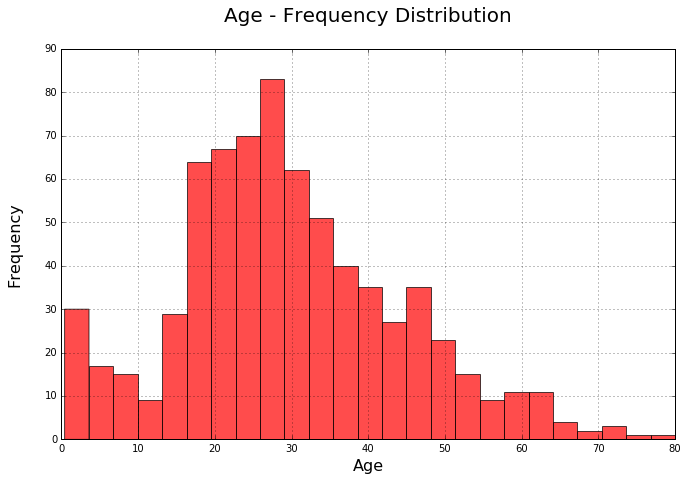

In [47]:
fig = plt.figure(figsize=(11,7))
fig = tita_data.Age.hist(bins=25, grid=True, alpha=0.7, color='r')
plt.title('Age - Frequency Distribution\n', fontsize = 20)
plt.ylabel('Frequency\n', fontsize = 16)
plt.xlabel('Age\n', fontsize = 16)
plt.show()

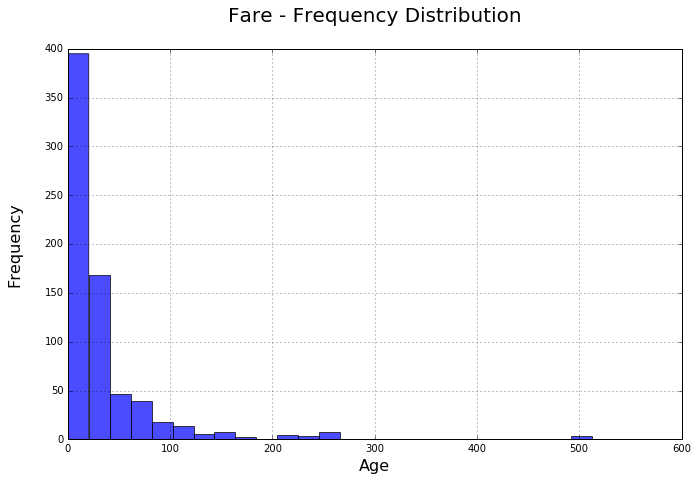

In [48]:
fig = plt.figure(figsize=(11,7))
fig = tita_data.Fare.hist(bins=25, grid=True, alpha=0.7, color='b')
plt.title('Fare - Frequency Distribution\n', fontsize = 20)
plt.ylabel('Frequency\n', fontsize = 16)
plt.xlabel('Age\n', fontsize = 16)
plt.show()

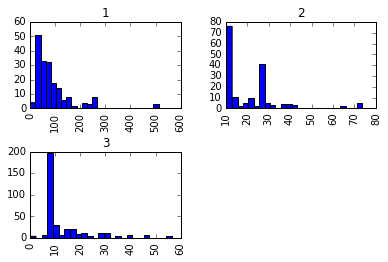

In [49]:
fig = plt.figure(figsize=(30,20))
fig = tita_data.Fare.hist(by=tita_data['Pclass'],  bins=25, grid=False)
plt.show()

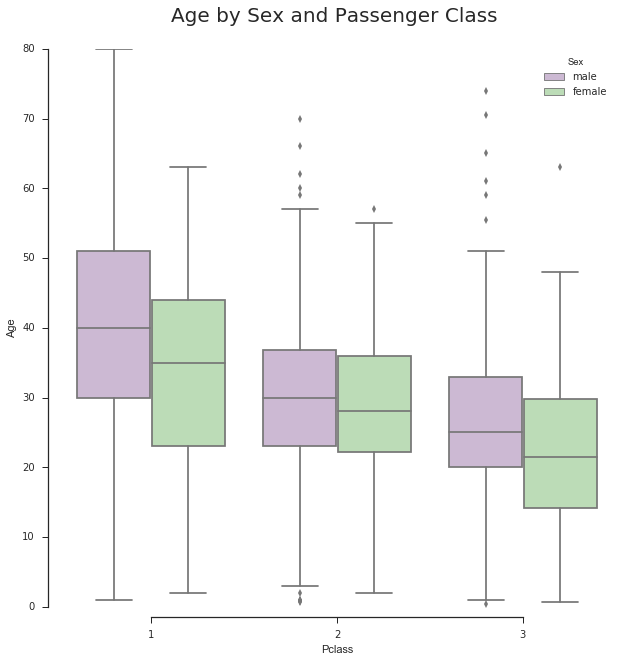

In [50]:
import seaborn as sns
fig = plt.figure(figsize=(10,10))
sns.set(style="ticks")

# Draw a nested boxplot to show bills by day and sex
sns.boxplot(x="Pclass", y="Age", hue="Sex", data=tita_data, palette="PRGn")
sns.despine(offset=10, trim=True)
plt.title('Age by Sex and Passenger Class \n', fontsize = 20)

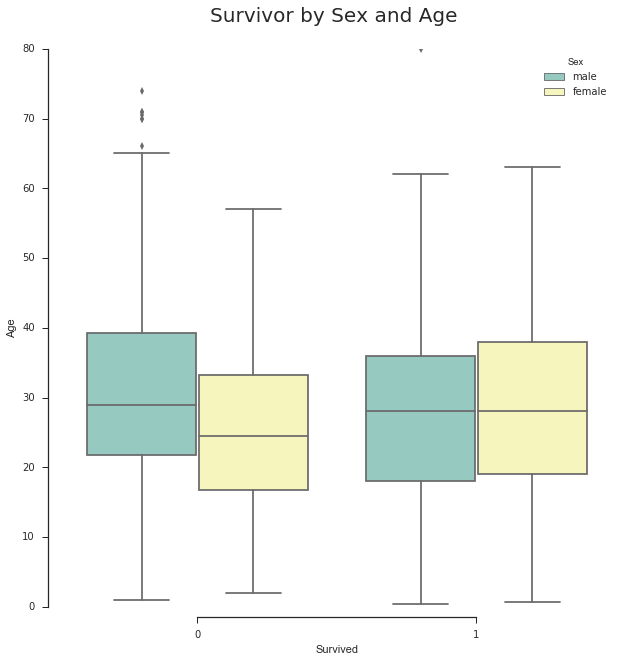

In [51]:
import seaborn as sns
fig = plt.figure(figsize=(10,10))
sns.set(style="ticks")

sns.boxplot(x="Survived", y="Age", hue="Sex", data=tita_data, palette="Set3")
sns.despine(offset=10, trim=True)
plt.title('Survivor by Sex and Age \n', fontsize = 20)

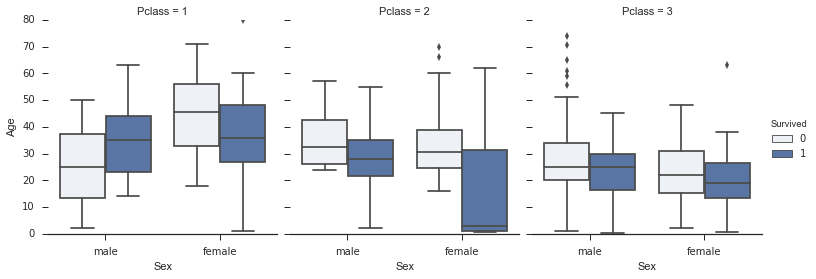

In [52]:
fig = plt.figure(figsize=(14,20))
g = sns.FacetGrid(tita_data, col="Pclass", size=4, aspect=.9)
(g.map(sns.boxplot, "Sex", "Age", "Survived")
.despine(left=True)
.add_legend(title="Survived"))  
plt.show()

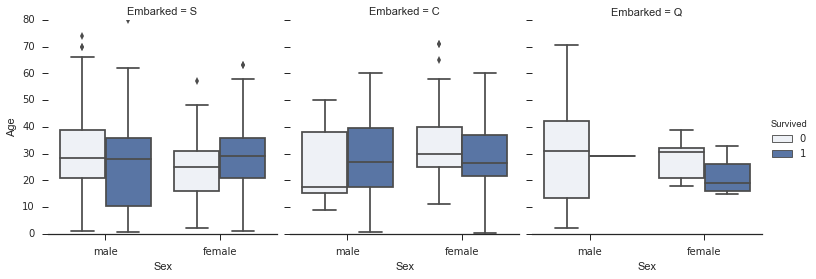

In [53]:
fig = plt.figure(figsize=(14,20))
g = sns.FacetGrid(tita_data, col="Embarked", size=4, aspect=.9)
(g.map(sns.boxplot, "Sex", "Age", "Survived")
.despine(left=True)
.add_legend(title="Survived"))
plt.show()

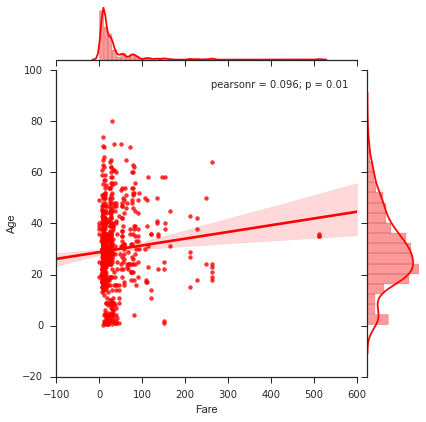

In [54]:
fig = plt.figure(figsize=(20,10))
fig = sns.jointplot("Fare", "Age", data=tita_data, kind="reg", color="r")
plt.show()

//anaconda/lib/python2.7/site-packages/seaborn/linearmodels.py:1285: UserWarning: The `corrplot` function has been deprecated in favor of `heatmap` and will be removed in a forthcoming release. Please update your code.
  warnings.warn(("The `corrplot` function has been deprecated in favor "
//anaconda/lib/python2.7/site-packages/seaborn/linearmodels.py:1351: UserWarning: The `symmatplot` function has been deprecated in favor of `heatmap` and will be removed in a forthcoming release. Please update your code.
  warnings.warn(("The `symmatplot` function has been deprecated in favor "


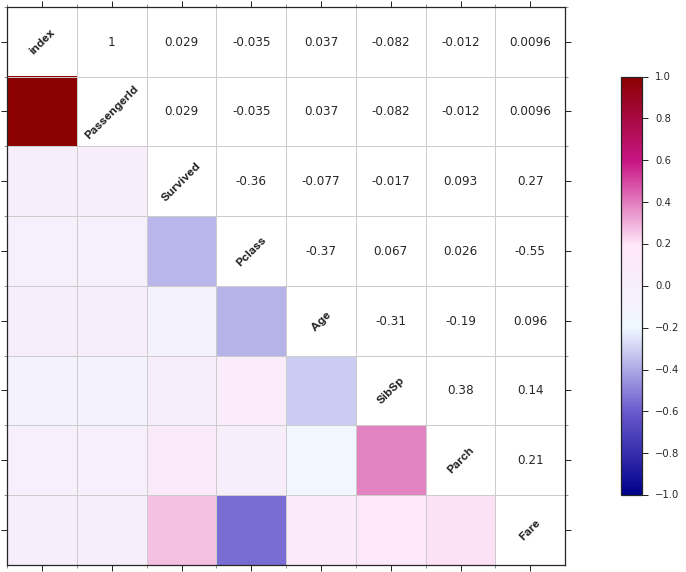

In [55]:
fig = plt.figure(figsize=(20,10))
cmap = sns.blend_palette(["#00008B", "#6A5ACD", "#F0F8FF",
                          "#FFE6F8", "#C71585", "#8B0000"], as_cmap=True)
sns.corrplot(tita_data, sig_stars=False, cmap=cmap)

## Part 3: Data Wrangling

#### 1. Create Dummy Variables for *Sex* 

In [56]:
def binary_function(x):
    return 1 if x == "male" else 0

tita_data['sex_bin'] = tita_data['Sex']
tita_data['sex_bin'] = tita_data.sex_bin.apply(binary_function)

In [57]:
tita_data.columns

Index([      u'index', u'PassengerId',    u'Survived',      u'Pclass',
              u'Name',         u'Sex',         u'Age',       u'SibSp',
             u'Parch',      u'Ticket',        u'Fare',       u'Cabin',
          u'Embarked',     u'sex_bin'],
      dtype='object')

In [58]:
tita_data.groupby(['Sex', 'sex_bin'])[['Age']].mean()

,,Age
Sex,sex_bin,
female,0,27.915709
male,1,30.726645


## Part 4: Logistic Regression and Model Validation

#### 1. Define the variables that we will use in our classification analysis

In [79]:
Y = tita_data['Survived']
X = tita_data[['Fare', 'Age', 'Pclass', 'sex_bin']]

#### 2. Transform "Y" into a 1-Dimensional Array for SciKit-Learn

In [80]:
Y_mat = np.array(Y)
print Y_mat.shape

(714,)


In [81]:
## Predictors in array format 
X_mat = X.values
X_cols = X.columns
# ## Normalizing Predictors ASK>>>>
X_mat = ((X - X.mean()) / X.std()).values

print X_mat.shape

(714, 4)


#### 3. Conduct the logistic regression

In [86]:
## Declarig the Logistic Regression
lr_reg = LogisticRegression()
lr_st_mod = lr_reg.fit(X_mat, Y_mat)

# lr_standard = LogisticRegression()
# lr_std_mod = lr_standard.fit(Xb_mat, Yb)

In [87]:
## Copy of Titanic data
tita_data_copy = tita_data.copy()

# ## Normalizing the data for patsy
# ## Standarizing the dataset
# nc = [x for x in tita_data_copy if x not in ['Survived']]
# tita_data_copy.ix[:, nc] = (tita_data_copy.ix[:, nc] - tita_data_copy.ix[:, nc].mean()) / tita_data_copy.ix[:, nc].std() 

In [88]:
## Using Patsy cause I have categorical data
import patsy
import statsmodels.formula.api as smf


formula = '''Survived ~ C(sex_bin) + C(Pclass) +
Age + Fare'''

# logit Regression
logreg = smf.logit(formula, data=tita_data_copy)
logreg_results = logreg.fit()
print logreg_results.summary()


Optimization terminated successfully.
         Current function value: 0.453242
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  714
Model:                          Logit   Df Residuals:                      708
Method:                           MLE   Df Model:                            5
Date:                Mon, 23 May 2016   Pseudo R-squ.:                  0.3290
Time:                        18:10:55   Log-Likelihood:                -323.61
converged:                       True   LL-Null:                       -482.26
                                        LLR p-value:                 1.919e-66
                      coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept           3.7225      0.465      8.014      0.000         2.812     4.633
C(sex_bin)[T.1

#### 4. Examine the coefficients to see our correlations

In [94]:
def make_coef_df(X_mat, mod):
    df = pd.DataFrame({'features':X.columns, 'coefs':mod.coef_[0]})
    return df

lr_std_coefs = make_coef_df(X_mat, lr_st_mod)
lr_std_coefs

,coefs,features
0,0.037751,Fare
1,-0.518286,Age
2,-1.037781,Pclass
3,-1.197460,sex_bin


#### 6. Test the Model by introducing a *Test* or *Validaton* set 

In [97]:
len(Y_mat)

714

In [98]:
## Train and split
X_train, X_test, y_train, y_test = train_test_split(X_mat, Y_mat, test_size=0.3, random_state =7)

## Testing Model
lr_reg.fit(X_train, y_train)
print "Train split score on test data:", lr_reg.score(X_test, y_test)


Train split score on test data: 0.786046511628


#### 7. Predict the class labels for the *Test* set

In [99]:
print lr_reg.predict(X_test)

[0 1 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 1 1 0 1 0 1 1 0 0
 1 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 1 1 0 1 0 0 0 1 1 1 1 0 0 0 0 0 1 1 0 0 1
 0 0 0 1 1 0 1 1 1 0 0 0 0 1 0 0 1 0 0 0 1 0 1 0 0 0 0 1 0 1 0 0 1 0 0 0 0
 1 0 1 1 0 1 0 0 1 0 0 1 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 1 1 1 0 1 1 1 0 1 0
 0 0 0 0 0 0 0 0 1 0 1 1 0 0 1 0 0 1 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 1 0 1 1
 1 1 0 0 0 1 0 0 1 0 1 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0]


#### 8. Predict the class probabilities for the *Test* set

In [100]:
predicted_probab = lr_reg.predict_proba(X_test)
print predicted_probab[0:5]

[[ 0.76744009  0.23255991]
 [ 0.05716377  0.94283623]
 [ 0.92961257  0.07038743]
 [ 0.04607105  0.95392895]
 [ 0.73910005  0.26089995]]


#### 9. Evaluate the *Test* set

In [101]:
print lr_reg.score(X_test, y_test)

0.786046511628


#### 10. Cross validate the test set

In [102]:
scores = cross_val_score(lr_reg, X_mat, Y_mat, cv=5)
print "Results of CV Scores:", scores, scores.mean()

Results of CV Scores: [ 0.75524476  0.83216783  0.78321678  0.75524476  0.8028169 ] 0.785738205457


#### 11. Check the Classification Report

In [103]:
from sklearn.metrics import classification_report

y_pred = lr_reg.predict(X_mat)
print(classification_report(Y_mat, y_pred, target_names = ['Not survived', 'Survived'] ))

              precision    recall  f1-score   support

Not survived       0.81      0.85      0.83       424
    Survived       0.76      0.71      0.73       290

 avg / total       0.79      0.79      0.79       714



#### 12. What do the classification metrics tell us?

#### 13. Check the Confusion Matrix

In [104]:
pd.crosstab(Y_mat, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,359,65,424
1,85,205,290
All,444,270,714


#### 14. What does the Confusion Matrix tell us? 

#### 15. Plot the ROC curve

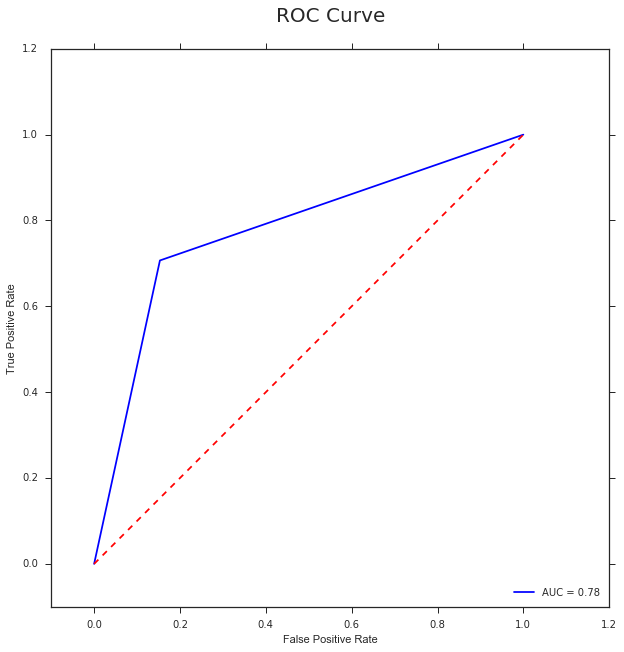

In [109]:
from sklearn.metrics import roc_curve, auc

FP, TP, thresholds = roc_curve(Y_mat, y_pred)
roc_auc = auc(FP, TP)


fig = plt.figure(figsize=(10,10))
plt.title('ROC Curve\n', fontsize =20)
plt.plot(FP, TP, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


#### 16. What does the ROC curve tell us?

## Part 5: Gridsearch

#### 1. Use GridSearchCV with logistic regression to search for optimal parameters 

- Use the provided parameter grid. Feel free to add if you like (such as n_jobs).
- Use 5-fold cross-validation.

In [110]:
from sklearn.grid_search import GridSearchCV

logreg_parameters = {
            'penalty':  ['l1','l2'],
            'C':        np.logspace(-5,1,50),
            'solver':   ['liblinear']
}

estimator = GridSearchCV(lr_reg, logreg_parameters, cv=5, verbose=1)

#### 2. Print out the best parameters and best score. Are they better than the vanilla logistic regression?

In [111]:
estimator.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 449 tasks       | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.8s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': array([  1.00000e-05,   1.32571e-05,   1.75751e-05,   2.32995e-05,
         3.08884e-05,   4.09492e-05,   5.42868e-05,   7.19686e-05,
         9.54095e-05,   1.26486e-04,   1.67683e-04,   2.22300e-04,
         2.94705e-04,   3.90694e-04,   5.17947e-04,   6.8...6e+00,   4.29193e+00,   5.68987e+00,
         7.54312e+00,   1.00000e+01]), 'solver': ['liblinear']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

In [112]:
print estimator.best_score_

0.793587174349


In [113]:
print estimator.best_params_

{'penalty': 'l2', 'C': 0.0625055192527397, 'solver': 'liblinear'}


In [114]:
y_true, y_pred = y_test, estimator.predict(X_test)
print classification_report(y_true, y_pred, target_names = ['Not survived', 'Survived'])

              precision    recall  f1-score   support

Not survived       0.79      0.87      0.83       126
    Survived       0.79      0.66      0.72        89

 avg / total       0.79      0.79      0.78       215



1. The parameter (best score = 0.793587174349) is slightly better than the one found in the previous calculations (score = 0.786046511628) 

#### 3. Explain the difference between the difference between the L1 (Lasso) and L2 (Ridge) penalties on the model coefficients.

After running the gridsearch, where I am passing the L1 and L2 penalties, the results suggest to use the L2 (Ridge) penalty as one of the best parameters. 
This implies that I should use all my coefficients since Ridge can't zero coefficients (it only shrinks the parameters). However Lasso, does both parameter shrinkage and variable selection automatic, as the method zero out the coefficients of collinear variables. When using Lasso, the technique helps to select the variable(s) out of a given n variables. 

#### 4. What hypothetical situations are the Ridge and Lasso penalties useful?

Ridge.
1. If the model needs bias, but smaller variance and smaller Mean Square Errors.
2. Therefore there is a need to keep all the regresors
3. Allows us to use all the predictors, even though a predictor X1 is selected at first (train data) when it is passed to the test data a different predictor X2 that is correlated to the X1 can have an explanatory variable. Therefore the need to keep both predictors X1 and X2


Lasso
1. When I need to be more selective on the predictors, or keep only those that have a better prediction among the set of variables that are correlated.
2. Is not good for group selection

#### 5. [BONUS] Explain how the regularization strength (C) modifies the regression loss function. Why do the Ridge and Lasso penalties have their respective effects on the coefficients?

In both escenarios the parameter C is directly related to the regularization parameter (lambda), where C is the inverse of lambda (C= 1/lambda). Meaning that as lambda increases the value of C decreases, and as we increase the value of lambda we increase the regularization strenght.
On each method, Ridge and Lasso the penalty is based on the sum of square of the betas for Ridge and and the absolute value of the sum of the betas in Lasso. 


#### 6.a. [BONUS] You decide that you want to minimize false positives. Use the predicted probabilities from the model to set your threshold for labeling the positive class to need at least 90% confidence. How and why does this affect your confusion matrix?

In [115]:
predicted_probabilities = lr_reg.predict_proba(X_mat)

In [116]:
y_new_pred = [0 if pp[0] > 0.90 else 1 for pp in predicted_probabilities]
print len(Y_mat), len(y_new_pred)

714 714


In [117]:
pd.crosstab(np.array(Y_mat), np.array(y_new_pred),
            rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,133,291,424
1,22,268,290
All,155,559,714


## Part 6: Gridsearch and kNN

#### 1. Perform Gridsearch for the same classification problem as above, but use KNeighborsClassifier as your estimator

At least have number of neighbors and weights in your parameters dictionary.

In [118]:
from sklearn.neighbors import KNeighborsClassifier
## Declaring the Knn Model
Knn = KNeighborsClassifier()

In [119]:
k = np.arange(20)+1

knn_parameters = {
          'n_neighbors' : k
}

estimator = GridSearchCV(Knn, knn_parameters, cv=5, verbose=1)

#### 2. Print the best parameters and score for the gridsearched kNN model. How does it compare to the logistic regression model?

In [120]:
estimator.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

In [121]:
print "Best estimator score:", estimator.best_score_
print "Best parametor Num of Neighboors:", estimator.best_params_

Best estimator score: 0.819639278557
Best parametor Num of Neighboors: {'n_neighbors': 5}


1. The best estimator score from the kNN model is higher (0.819639278557) than the scores previously found (best score = 0.793587174349) and  (score = 0.786046511628) 

#### 3. How does the number of neighbors affect the bias-variance tradeoff of your model?

#### [BONUS] Why?

1. A smaller number of neighbors means a higher variancean lower bias.
2. A higher number of neighbors means lower variace and higher bias.

#### 4. In what hypothetical scenario(s) might you prefer logistic regression over kNN, aside from model performance metrics?

1. Training: k-nearest neighbors requires no training. Logistic regression requires some training. On the other hand, in k-nearest neighbors, one needs to tune  kk . Logistic regression doesn't need any parameter tuning.
2. Decision boundary: Logistic regression learns a linear classifier, while k-nearest neighbors can learn non-linear boundaries as well.
3. Predicted values: Logistic regression predicts probabilities, which are a measure of the confidence of prediction. k-nearest neighbors predicts just the labels.
4. Logistic regression is pretty robust to noise and one can avoid overfitting and even do feature selection by using l2 or l1 regularization.

#### 5. Fit a new kNN model with the optimal parameters found in gridsearch. 

In [122]:
knn_5neighbors = KNeighborsClassifier(n_neighbors=5)
knn5 = knn_5neighbors.fit(X_mat, Y_mat)
print np.mean(Y_mat)
print 'knn5 acc:', knn5.score(X_mat, Y_mat)

0.406162464986
knn5 acc: 0.868347338936


#### 6. Construct the confusion matrix for the optimal kNN model. Is it different from the logistic regression model? If so, how?

In [123]:
y_pred = knn5.predict(X_mat)
print y_pred.shape, Y_mat.shape

pd.crosstab(Y_mat, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

(714,) (714,)


Predicted,0,1,All
True,,,
0,387,37,424
1,57,233,290
All,444,270,714


#### 7. [BONUS] Plot the ROC curves for the optimized logistic regression model and the optimized kNN model on the same plot.

In [124]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

## Optimal Logistic Regresion:
clf1 = LogisticRegression(penalty='l2', 
                          C=0.0625055192527397,
                          random_state=0)
## Optimal kNN classifier
clf3 = KNeighborsClassifier(n_neighbors=5,
                            p=2,
                            metric='minkowski')

pipe1 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf1]])

pipe3 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf3]])

clf_labels = ['Logistic Regression', 'KNN']

print('10-fold cross validation:\n')
for clf, label in zip([pipe1, clf3, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_mat,
                             y=Y_mat,
                             cv=10,
                             scoring='roc_auc')
    
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

10-fold cross validation:

ROC AUC: 0.85 (+/- 0.03) [Logistic Regression]
ROC AUC: 0.86 (+/- 0.05) [KNN]


2 2 2 2


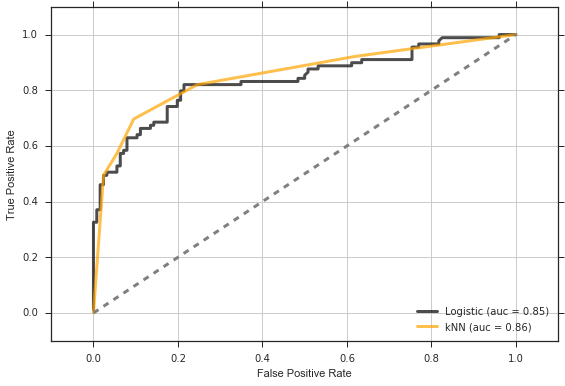

In [125]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

all_clf = [pipe1, pipe3]#, mv_clf]
colors = ['black', 'orange']
linestyles = ['-', '-']
labels = ['Logistic', 'kNN']

#fig = plt.figure(figsize=(9,7))

print len(all_clf), len(labels), len(colors), len(linestyles)

for clf, label, color, ls in zip(all_clf, labels, colors, linestyles):
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    
    roc_auc = cross_val_score(estimator=clf,
                             X=X_mat,
                             y=Y_mat,
                             cv=10,
                             scoring='roc_auc').mean()
    
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    #roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, color=color, ls=ls, label='%s (auc = %0.2f)' % (label, roc_auc),
             lw=3, alpha=0.7)

plt.legend(loc='lower right')

plt.plot([0, 1], [0, 1],
         linestyle='--',
         color='gray',
         linewidth=3)

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.tight_layout()

plt.show()

## Part 7: [BONUS] Precision-recall

#### 1. Gridsearch the same parameters for logistic regression but change the scoring function to 'average_precision'

`'average_precision'` will optimize parameters for area under the precision-recall curve instead of for accuracy.

In [126]:
logreg_parameters = {
            'penalty':  ['l1','l2'],
            'C':        np.logspace(-5,1,50),
            'solver':   ['liblinear']
}

estimator = GridSearchCV(lr_reg, logreg_parameters, scoring = 'average_precision', cv=5, verbose=1)

#### 2. Examine the best parameters and score. Are they different than the logistic regression gridsearch in part 5?

In [127]:
estimator.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 449 tasks       | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.2s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': array([  1.00000e-05,   1.32571e-05,   1.75751e-05,   2.32995e-05,
         3.08884e-05,   4.09492e-05,   5.42868e-05,   7.19686e-05,
         9.54095e-05,   1.26486e-04,   1.67683e-04,   2.22300e-04,
         2.94705e-04,   3.90694e-04,   5.17947e-04,   6.8...6e+00,   4.29193e+00,   5.68987e+00,
         7.54312e+00,   1.00000e+01]), 'solver': ['liblinear']},
       pre_dispatch='2*n_jobs', refit=True, scoring='average_precision',
       verbose=1)

In [128]:
print "Best score: ", estimator.best_score_
print "Best parameter: ", estimator.best_params_

Best score:  0.839388355129
Best parameter:  {'penalty': 'l1', 'C': 0.020235896477251575, 'solver': 'liblinear'}


1. The score is higher than the previous analysis 
2. The new analysis suggest the use of Lasso instead of Ridge (suggested in the previous analysis)

#### 3. Create the confusion matrix. Is it different than when you optimized for the accuracy? If so, why would this be?

In [129]:
y_pred = lr_reg.predict(X_mat)
print y_pred.shape, Y_mat.shape

pd.crosstab(Y_mat, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

(714,) (714,)


Predicted,0,1,All
True,,,
0,359,65,424
1,85,205,290
All,444,270,714


In [130]:
y_true, y_pred = y_test, estimator.predict(X_test)
print classification_report(y_true, y_pred, target_names = ['Not survived', 'Survived'])

              precision    recall  f1-score   support

Not survived       0.77      0.85      0.81       126
    Survived       0.75      0.64      0.69        89

 avg / total       0.76      0.76      0.76       215



#### 4. Plot the precision-recall curve. What does this tell us as opposed to the ROC curve?

[See the sklearn plotting example here.](http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html)

Area Under Curve: 0.55


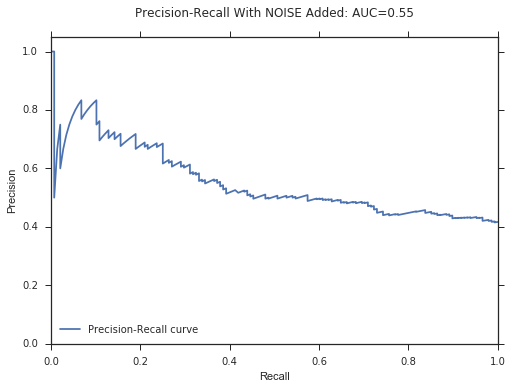

In [131]:
#http://ogrisel.github.io/scikit-learn.org/sklearn-tutorial/auto_examples/plot_precision_recall.html
import random
import pylab as pl
from sklearn import svm 
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

n_samples, n_features = X_mat.shape
p = range(n_samples)  # Shuffle samples
random.seed(0)
random.shuffle(p)
X, y = X_mat[p], Y_mat[p]
half = int(n_samples / 2)

# Add noisy features
np.random.seed(0)
X = np.c_[X, np.random.randn(n_samples, 200 * n_features)]

# Run classifier
classifier = svm.SVC(kernel='linear', probability=True)
probas_ = classifier.fit(X[:half], y[:half]).predict_proba(X[half:])

# Compute Precision-Recall and plot curve
precision, recall, thresholds = precision_recall_curve(y[half:], probas_[:, 1])
area = auc(recall, precision)
print "Area Under Curve: %0.2f" % area

pl.clf()
pl.plot(recall, precision, label='Precision-Recall curve')
pl.xlabel('Recall')
pl.ylabel('Precision')
pl.ylim([0.0, 1.05])
pl.xlim([0.0, 1.0])
pl.title('Precision-Recall With NOISE Added: AUC=%0.2f\n' % area)
pl.legend(loc="lower left")
pl.show()



In [132]:
from sklearn.svm import SVC
from sklearn.metrics import precision_recall_curve, average_precision_score

In [133]:
# Declare classifier
classifier = SVC(kernel='linear', probability=True)
probas_ = classifier.fit(X_train, y_train).predict_proba(X_test)

# Compute precision, recall and threshold
precision, recall, thresholds = precision_recall_curve(y_test, probas_[:, 1])

In [134]:
print precision[:5]

[ 0.41588785  0.41314554  0.41509434  0.41706161  0.41428571]


In [135]:
from sklearn.metrics import auc

area = auc(recall, precision)
print "Area under the curve: %0.3f" % area 

Area under the curve: 0.792


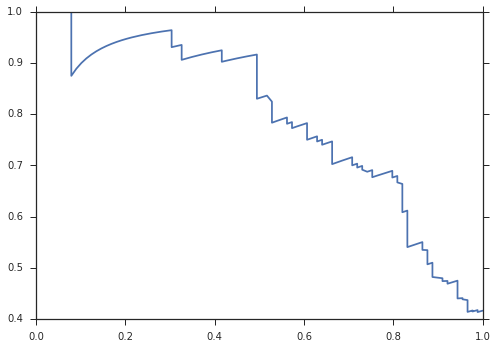

In [136]:
plt.clf()
plt.plot(recall, precision, label="AUC = %0.2f" % roc_auc)

## Part 8: [VERY BONUS] Decision trees, ensembles, bagging

#### 1. Gridsearch a decision tree classifier model on the data, searching for optimal depth. Create a new decision tree model with the optimal parameters.

In [189]:
from sklearn.grid_search import GridSearchCV

Y = tita_data['Survived']
X = tita_data[['Fare', 'Age', 'Pclass', 'sex_bin']]

dt = DecisionTreeClassifier()

In [190]:
params = {"max_depth": [3,5,10,20],
          "max_features": [None, "auto"],
          "min_samples_leaf": [1, 3, 5, 7, 10],
          "min_samples_split": [2, 5, 7]
         }
    

gsdt = GridSearchCV(dt, params, n_jobs=-1, cv=5,verbose=1)

In [191]:
print gsdt.fit(X, Y)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done 368 tasks      | elapsed:    1.6s


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_features': [None, 'auto'], 'min_samples_split': [2, 5, 7], 'max_depth': [3, 5, 10, 20], 'min_samples_leaf': [1, 3, 5, 7, 10]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    2.1s finished


In [192]:
print gsdt.best_params_

{'max_features': 'auto', 'min_samples_split': 2, 'max_depth': 10, 'min_samples_leaf': 3}


In [193]:
print gsdt.best_score_

0.824929971989


#### 2. Compare the performace of the decision tree model to the logistic regression and kNN models.

The best score parameter is close in value to the ones found in the logistic regression and kNN model.

#### 3. Plot all three optimized models' ROC curves on the same plot. 

In [177]:
## Best decision tree
clf4 = DecisionTreeRegressor(max_features = None,
                            min_samples_split = 2, 
                            splitter ='random', 
                            max_depth =10, 
                            min_samples_leaf =3)

pipe4 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf4]])
clf4

DecisionTreeRegressor(criterion='mse', max_depth=10, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=3, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='random')

In [171]:
# from sklearn.metrics import roc_curve
# from sklearn.metrics import auc

# all_clf = [pipe1, pipe3, pipe4]#, mv_clf]
# colors = ['black', 'orange', 'black']
# linestyles = ['-', '-', '-']
# labels = ['Logistic', 'kNN', 'Decision Tree']

# #fig = plt.figure(figsize=(9,7))

# print len(all_clf), len(labels), len(colors), len(linestyles)

# for clf, label, color, ls in zip(all_clf, labels, colors, linestyles):
#     y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    
#     roc_auc = cross_val_score(estimator=clf,
#                              X=X_mat,
#                              y=Y_mat,
#                              cv=10,
#                              scoring='roc_auc').mean()
    
#     fpr, tpr, _ = roc_curve(y_test, y_pred)
#     #roc_auc = auc(fpr, tpr)
    
#     plt.plot(fpr, tpr, color=color, ls=ls, label='%s (auc = %0.2f)' % (label, roc_auc),
#              lw=3, alpha=0.7)

# plt.legend(loc='lower right')

# plt.plot([0, 1], [0, 1],
#          linestyle='--',
#          color='gray',
#          linewidth=3)

# plt.xlim([-0.1, 1.1])
# plt.ylim([-0.1, 1.1])
# plt.grid()
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')

# plt.tight_layout()

# plt.show()

#### 4. Use sklearn's BaggingClassifier with the base estimator your optimized decision tree model. How does the performance compare to the single decision tree classifier?

In [203]:
from sklearn.ensemble import BaggingClassifier

In [205]:
bagging_tree = BaggingClassifier(gsdt.best_estimator_)
bagging_tree.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features='auto', max_leaf_nodes=None, min_samples_leaf=3,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=10, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [208]:
print cross_val_score(bagging_tree, X_train, y_train, cv=5).mean()

0.819669966997


#### 5. Gridsearch the optimal n_estimators, max_samples, and max_features for the bagging classifier.

In [150]:

from sklearn.tree import DecisionTreeClassifier

params = {"base_estimator__max_depth": [3,5,10,20],
          "base_estimator__max_features": [None, "auto"],
          "base_estimator__min_samples_leaf": [1, 3, 5, 7, 10],
          "base_estimator__min_samples_split": [2, 5, 7],
          'bootstrap_features': [False, True],
          'max_features': [0.5, 0.7, 1.0],
          'max_samples': [0.5, 0.7, 1.0],
          'n_estimators': [2, 5, 10, 20],
         }

bagged_decision_trees = BaggingClassifier(DecisionTreeClassifier())

gsbdt = GridSearchCV(bagged_decision_trees, params, n_jobs=-1, cv=5, verbose=1)

In [151]:
print gsbdt.fit(X, Y)

Fitting 5 folds for each of 8640 candidates, totalling 43200 fits


[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 1112 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done 2612 tasks      | elapsed:   51.1s
[Parallel(n_jobs=-1)]: Done 4712 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 7412 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 10712 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 14612 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 19112 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 24212 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 29912 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 36212 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 43112 tasks      | elapsed: 13.9min
[Parallel(n_jobs=-1)]: Done 43200 out of 43200 | elapsed: 13.9min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, ...n_estimators=10, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [2, 5, 10, 20], 'max_samples': [0.5, 0.7, 1.0], 'base_estimator__min_samples_split': [2, 5, 7], 'base_estimator__max_depth': [3, 5, 10, 20], 'bootstrap_features': [False, True], 'max_features': [0.5, 0.7, 1.0], 'base_estimator__min_samples_leaf': [1, 3, 5, 7, 10], 'base_estimator__max_features': [None, 'auto']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)


In [152]:
print gsbdt.best_score_

0.829131652661


In [153]:
print gsbdt.best_params_

{'max_samples': 1.0, 'base_estimator__min_samples_split': 7, 'base_estimator__max_depth': 20, 'base_estimator__max_features': 'auto', 'n_estimators': 5, 'max_features': 1.0, 'base_estimator__min_samples_leaf': 3, 'bootstrap_features': False}


#### 6. Create a bagging classifier model with the optimal parameters and compare it's performance to the other two models.

In [ ]:
bagged_decision_trees = BaggingClassifier(DecisionTreeClassifier())

In [210]:
# param_b = {'max_samples': [1.0], 'base_estimator__min_samples_split': [7],
#            'base_estimator__max_depth': [20], 'base_estimator__max_features': ['auto'],
#            'n_estimators': [5], 'max_features': [1.0], 'base_estimator__min_samples_leaf': [3], 
#            'bootstrap_features': [False]}

In [214]:
bagged_decision_trees = BaggingClassifier(DecisionTreeClassifier())

In [216]:
gsdt_pred = gsbdt.best_estimator_.predict(X_test)

In [218]:
pd.DataFrame({'predicted': gsdt_pred, 'actual': y_test}).head()

,actual,predicted
0,0,1
1,1,1
2,0,1
3,1,1
4,0,1
